# Spatial Transcriptomics Demo of HM-OT

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np

import sys
import os
import importlib
import torch
sys.path.append(os.path.abspath(".."))

import src.HiddenMarkovOT as HiddenMarkovOT
import src.utils.util_LR as util_LR
from src.utils.util_LR import convert_adata
import src.plotting as plotting
util_LR.seed_everything(42)

### Dataset

For this demonstration, we use spatial transcriptomics data from **Chen et al. (2022)**  
([Cell, 2022](https://www.cell.com/cell/fulltext/S0092-8674(22)00399-3)),  
which mapped mouse embryonic development at single-cell resolution with Stereo-Seq.

The data is publicly available via the [MOSTA](https://db.cngb.org/stomics/datasets/STDS0000058/data) database.

We select spatial datasets from three developmental stages for this first example:

- **E10.5**
- **E11.5**
- **E12.5**

We first preprocess the data minimally, annotating each with timepoints, intersecting common genes, concatenating and then performing a consistent normalization, log-transform, and joint PCA for a set of common embeddings of the varied timepoints.

In [2]:

filehandles_embryo_adata = [
                            '/scratch/gpfs/ph3641/mouse_embryo/E11.5_E1S1.MOSTA.h5ad', \
                            '/scratch/gpfs/ph3641/mouse_embryo/E12.5_E1S1.MOSTA.h5ad', \
                            '/scratch/gpfs/ph3641/mouse_embryo/E13.5_E1S1.MOSTA.h5ad']

timepoints = [ 'E11.5', 'E12.5', 'E13.5'] 

# Load adatas and set count layer and timepoints
print('Loading mouse-embryo AnnDatas')
adatas = []
for i, fh in enumerate(filehandles_embryo_adata):
    adata = sc.read_h5ad(fh)
    adata.X = adata.layers['count']
    adata.obs['timepoint'] = [timepoints[i]] * adata.shape[0]
    adatas.append(adata)

# Find intersection of genes across all adatas
common_genes = set(adatas[0].var.index)
for adata in adatas[1:]:
    common_genes &= set(adata.var.index)
common_genes = list(common_genes)

# Subset each adata to the common genes
adatas = [adata[:, common_genes] for adata in adatas]
adata_pairs = []

print('Starting PCA')

# Compute pairwise PCA (so it's scalable) for each AnnData (t, t+1)
for i in range(len(adatas) - 1):
    ad1, ad2 = adatas[i], adatas[i+1]
    t1, t2 = timepoints[i], timepoints[i+1]
    
    # 1) Normalize + log-transform both slices independently
    joint = ad.concat([ad1, ad2], join='inner')
    sc.pp.normalize_total(joint)
    sc.pp.log1p(joint)
    sc.pp.pca(joint, n_comps=30)
    # Free up memory by clearing X and heavy layers
    joint.X = None
    if 'count' in joint.layers:
        del joint.layers['count']
    adata_pairs.append(joint)

print('PCA Finished!')

Loading mouse-embryo AnnDatas
Starting PCA


/home/ph3641/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ph3641/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


PCA Finished!


### Running HM-OT

Now that we’ve constructed an `AnnData` object containing:

- The **timepoints** of interest (in `.obs['timepoint']`)
- **Lower-dimensional features** for cost computation (in `.obsm['X_pca']`)
- **Cell-type annotations** (in `.obs['annotation']`)
- **Spatial coordinates** (in `.obs[['x_loc', 'y_loc']]` or `.obsm['spatial']`)

...we're ready to run **Hidden Markov Optimal Transport (HM-OT)** (again)!

Since this is a **spatial transcriptomics dataset**, we set `spatial=True` in the preprocessing.

As before, we configure the low-rank approximation parameters for the pairwise distance matrices:

- `dist_rank` — the rank for approximating the **inter-timepoint cost matrix** $C^{(t,t+1)}$
- `dist_rank_2` — the rank for approximating the **intra-timepoint cost matrices** $A^{(t)}$ (used when spatial structure is available)
- `dist_eps` — the allowed approximation error (higher values relax the low-rank accuracy)

As before, lowering `dist_rank` or increasing `dist_eps` reduces memory usage and speeds up computations, at the cost of reduced approximation fidelity.

In [3]:

from src.utils.util_LR import convert_adata_pairwise

# Set torch device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert AnnData in HM-OT ready factors
C_factors_sequence, A_factors_sequence, Qs, labels, rank_list, spatial_list = convert_adata_pairwise(adata_pairs,
                                                                                    timepoints=timepoints,
                                                                                     timepoint_key = 'timepoint',
                                                                                     replicate_key = 'embryo_id',
                                                                                     feature_key = 'X_pca',
                                                                                     cell_type_key = 'annotation',
                                                                                     spatial = True,
                                                                                     spatial_key = ['x_loc', 'y_loc'],
                                                                                     fallback_spatial_key = 'spatial',
                                                                                     dist_eps = 0.02,
                                                                                     dist_rank = 100,
                                                                                     dist_rank_2 = 50,
                                                                                     device = device,
                                                                                    normalize=True
                                                                                )

### Building a Differentiation Map with Spatial Information

Now, we're ready to run **HM-OT** on the preprocessed spatial transcriptomics data.

In this example, we infer the sequence of differentiation maps $(\mathbf{T}^{(t,t+1)})_{t=1}^{n-1}$ across the selected timepoints.

Since spatial coordinates are available, we introduce an additional parameter, $\alpha$, which balances expression-based and spatial-based costs.

- Setting $\alpha = 0$ recovers the standard single-cell variant of HM-OT, using only gene expression information.
- Increasing $\alpha > 0$ progressively upweights the contribution of spatial proximity in the transport problem.

This allows HM-OT to flexibly integrate both transcriptomic and spatial information when modeling cell-state transitions. In particular, when $\alpha > 0$, the objective solved by HM-OT becomes a **fused Gromov-Wasserstein (FGW)** loss, which simultaneously accounts for both feature and spatial structure. Another key hyperparameter is **$\gamma$**, which controls the level of **entropy regularization** which scales as **$1/\gamma$**:

- Higher values of $\gamma$ produce sharper and more deterministic transitions between clusters.
- Lower values of $\gamma$ allow for softer and more distributed transitions, which may better capture gradual differentiation.

Choosing $\alpha$ and $\gamma$ appropriately is important for correctly capturing differentiation.

The low-rank optimal transport solver used for FGW here is based on the framework introduced in:

> Halmos, P., Liu, X., Gold, J., and Raphael, B. (2024). 
> [Low-Rank Optimal Transport through Factor Relaxation with Latent Coupling](https://proceedings.neurips.cc/paper_files/paper/2024/file/cfc1924c62e72e2cb0e0feeecb963241-Paper-Conference.pdf), NeurIPS 2024.


Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25


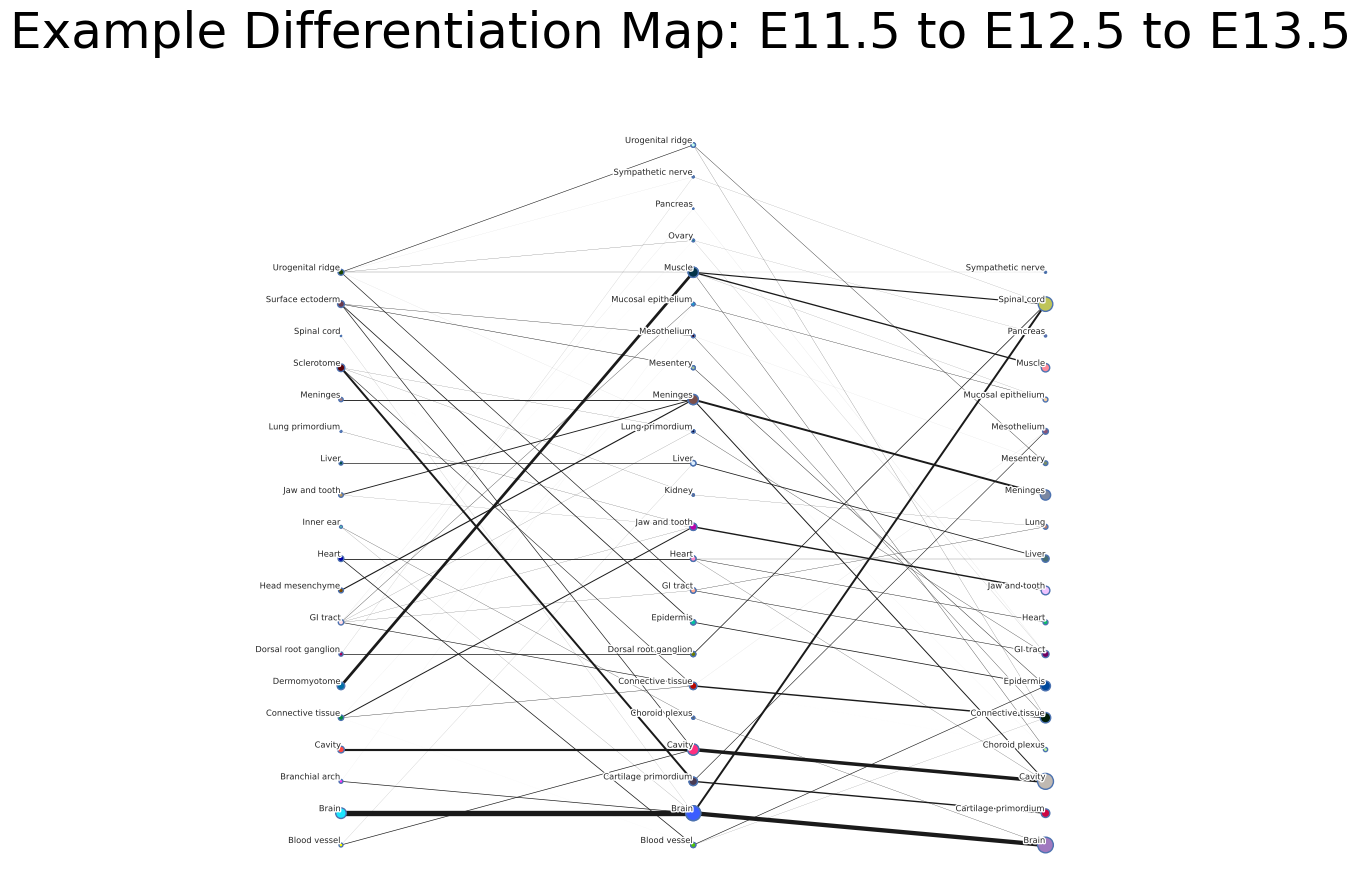

In [4]:

# Initialize HM-OT with hyperparameters, set printCost = True to see progress on loss

hmot = HiddenMarkovOT.HM_OT(rank_list,
                            tau_in = 1e-3,
                            tau_out = 1e-3,
                            gamma = 80,
                            max_iter = 30,
                            min_iter = 30,
                            device=device,
                            alpha = 0.9999,
                            dtype=torch.float32,
                            printCost=False,
                            returnFull=False,
                            initialization='Full'
                            )

# Run HM-OT to infer annotated transitions
hmot.impute_annotated_transitions(C_factors_sequence, A_factors_sequence, Qs)

# We can now load the transitions and annotated cell-types
Ts_hmot = [T.cpu().numpy() for T in hmot.T_gammas]
Qs_ann = [Q.cpu().numpy() for Q in Qs]

# Visualize the inferred differentiation map
plotting.diffmap_from_QT(Qs_ann, Ts_hmot, labels, dsf=0.01, fontsize=6, linethick_factor=20, \
                         title= f'Example Differentiation Map: {timepoints[0]} to {timepoints[1]} to {timepoints[2]}',
                        save_name = os.path.join("/scratch/gpfs/ph3641/hm_ot/ME_supervised_figs/diff_map_ME_Demo.png" ))


### Mapping Annotated Cell-Types Through Time

Once HM-OT has inferred the transitions between timepoints, we can propagate cluster or cell-type annotations through time.

- Setting a **reference index** allows you to choose where to start the mapping.
- Choosing an **early timepoint** (small `reference_index`) tracks **descendants** forward through development.
- Choosing a **late timepoint** (larger `reference_index`) traces **ancestors** backward in time.

Below, we visualize the differentiation trajectory starting from different reference timepoints. If this exceeds memory limitations for a dataset, set `full_P=False`. This will be slower but compute the clustering in a much more space efficient manner.

In [ ]:
importlib.reload(plotting)

# Tracking descendant cells backward in time
plotting.plot_clusters_from_QT(
            spatial_list, Qs_ann, Ts_hmot, None, 
            clustering_type='reference', 
            reference_index=2, 
            flip=True, 
            dotsize=10)


![Alt text](E11.5_12.5_13.5.png)

### Co-cluster Inference Through Transfer

In this example, we demonstrate how **HM-OT** can be used for **cluster-transfer** and **missing annotation imputation** in partially labeled datasets. 

Suppose one has $n$ datasets where $n-r$ have known annotations and $r$ datasets have missing or incomplete annotations. **HM-OT** can be used to transfer the annotations across samples, even when data which is not necessarily temporal, so long as all datasets share a common space (e.g. spatial coordinates, expression coordinates, both, and so on). This enables **semi-supervised** or **unsupervised** clustering in sequential data.

When learning "unsupervised" clusters, one can freely choose a number of key variables of interest:

- `proportions`: a list of $n$ 1D `torch.Tensor` objects specifying the desired cell-type proportions for each dataset.  
  If set to `False` (default), proportions are initialized uniformly and learned during optimization.
- `tau_in`: a (mirror-descent) step-size variable for the learning proportions. Setting `tau_in` larger (e.g. `tau_in=1000`) means the step-size will be smaller, which tends to be more stable. Smaller `tau_in` allows for faster deviations from the initial default proportions (uniform or the user input proportions) but may be less stable.
- `rank_list`: list of tuples `[(r₁, r₂), (r₂, r₃), ...]` specifying the number of clusters at each timepoint pair. These define the dimensions of the soft cluster assignment matrices and the rank of the low-rank OT maps.
- `tau_out`: regularization strength controlling how much mass is allowed to vary across the marginal distributions $(a_t)_{t=1}^n$. Larger values encourage more strictly balanced mappings across timepoints; smaller values allow more mass shift.
- `Qs_IC`: initial conditions for the cluster assignments. This is a list of cluster assignment matrices (tensors) used to warm-start the optimization.
- `Qs_freeze`: list of booleans specifying which timepoints have **fixed** clusters (True) and which are **learned** (False). This allows labeled datasets to propagate cluster identities to unlabeled datasets.
- `warmup`: whether to perform a warm-start round on the transitions $(\mathbf{T}^{(t,t+1)})_{t=1}^{n-1}$ before inferring the clusterings. This is useful when all timepoints have annotated labels and you want to initialize the transitions before learning cluster assignments.


### One-Way Cluster Transfer Example

As a concrete demonstration of semi-supervised cluster inference, we perform a **simple pairwise transfer** of annotations.

In this case, we assume that only the **first** dataset is annotated. Using HM-OT, we propagate those cluster labels **forward** to the second dataset, without requiring a ground-truth clustering for the second timepoint.

We do this by setting:

- `Qs_freeze = [True, False]`: freezing the clustering on the first timepoint and learning it on the second.
- `Qs_IC`: providing a known cluster assignment (Q matrix) only for the first timepoint.
- `warmup = False`: we skip warm-starting the transitions, and infer both the map and the clusters jointly.

This setup demonstrates how HM-OT can serve as a **cluster transfer mechanism** across timepoints, conditions, batches, or a spatial axis — even in spatial or non-transcriptomic settings.

Below, we visualize the transferred clusters at both timepoints, using a forward-propagation from the annotated sample.

In [ ]:

importlib.reload(HiddenMarkovOT)

# Initialize HM-OT
hmot_partial = HiddenMarkovOT.HM_OT(
                            rank_list[:-1],
                            tau_in = 1e-3,
                            tau_out = 1e-3,
                            gamma = 80,
                            max_iter = 30,
                            min_iter = 30,
                            device=device,
                            alpha = 0.9999,
                            dtype = torch.float32,
                            printCost = False,
                            returnFull = False,
                            initialization = 'Full'
                           )

# Run HM-OT with Qs_IC from only timepoint 1, and freeze it
hmot_partial.gamma_smoothing(C_factors_sequence[:-1],
                     A_factors_sequence[:-1],
                     Qs_IC = [Qs[0], None],
                     Qs_freeze = [True, False],
                    warmup = False
                    )

# Extract outputs
Qs_hmot_partial = [Q.cpu().numpy() for Q in hmot_partial.Q_gammas]
Ts_hmot_partial = [T.cpu().numpy() for T in hmot_partial.T_gammas]

# Visualize the transfer from time 1 to time 2
plotting.plot_clusters_from_QT(spatial_list[:-1], Qs_hmot_partial,
                               Ts_hmot_partial, None, clustering_type='reference',
                               reference_index=0, flip=True, dotsize=10)


![Alt text](Cluster_Transfer.png)

### One-Way Cluster Transfer Example 2

We repeat the previous example, but now for the latter two timepoints.

In [ ]:

hmot_partial = HiddenMarkovOT.HM_OT(
                            rank_list[1:],
                            tau_in = 1e-3,
                            tau_out = 1e-3,
                            gamma = 80,
                            max_iter = 50,
                            min_iter = 50,
                            device=device,
                            alpha = 0.99993,
                            dtype = torch.float32,
                            printCost = False,
                            returnFull = False,
                            initialization = 'Full'
                           )

hmot_partial.gamma_smoothing(C_factors_sequence[1:],
                     A_factors_sequence[1:],
                     Qs_IC = [None, Qs[2]],
                     Qs_freeze = [False, True],
                    warmup = False
                    )

# Plotting results
Qs_hmot_partial = [Q.cpu().numpy() for Q in hmot_partial.Q_gammas]
Ts_hmot_partial = [T.cpu().numpy() for T in hmot_partial.T_gammas]


In [ ]:
plotting.plot_clusters_from_QT(spatial_list[1:], \
                               Qs_hmot_partial, Ts_hmot_partial, \
                               None, clustering_type='reference', \
                               reference_index=1, flip=True, dotsize=10)

![Alt text](Cluster_Transfer2.png)

# Co-cluster inference (Unfinished / In Progress, will update!)

In [ ]:
"""
Can input proportions of clusters, if desired, to fix during optimization.
Optional, but recommended if running fully unsupervised and you know approximately what proportions should be.
"""


# Here, we keep the input cell-type proportions consistent with the annotation.
proportions = [torch.sum(torch.tensor(Qs[i]).to(torch.float32), axis=0) for i in range(len(Qs))]


# Example : triple of timepoints
hmot_partial = HiddenMarkovOT.HM_OT(
                            rank_list,
                            tau_in = 1e-3,
                            tau_out = 1e-3,
                            gamma = 80,
                            max_iter = 30,
                            min_iter = 30,
                            device=device,
                            alpha = 0.9999,
                            dtype = torch.float32,
                            printCost = False,
                            returnFull = False,
                            initialization = 'Full',
                            proportions = proportions
                           )

"""
Can fix and freeze any subset of types and infer missing ones!
Let's attempt a transfer of the cell-types from E13.5 to the other timepoints.
"""

"""
hmot_partial.gamma_smoothing(C_factors_sequence,
                     A_factors_sequence,
                     Qs_IC = [None, None, Qs[2]],
                     Qs_freeze = [False, False, True],
                    warmup = False
                    )

# Plotting results
Qs_hmot_partial = [Q.cpu().numpy() for Q in hmot_partial.Q_gammas]
Ts_hmot_partial = [T.cpu().numpy() for T in hmot_partial.T_gammas]
plotting.plot_clusters_from_QT(spatial_list, Qs_hmot_partial, Ts_hmot_partial, None, clustering_type='reference', reference_index=0, flip=True, dotsize=10)
plotting.plot_clusters_from_QT(spatial_list, Qs_hmot_partial, Ts_hmot_partial, None, clustering_type='reference', reference_index=2, flip=True, dotsize=10)
"""


In [ ]:
"""
importlib.reload(HiddenMarkovOT)

# Can input proportions of clusters, if desired, to fix during optimization.
# If learning the proportions from scratch, it's more stable to set the step-size (tau_in) on the cluster proportions to be low (tau_in to be high -- e.g. 1000)
proportions = [torch.sum(torch.tensor(Qs[i]).to(torch.float32), axis=0) for i in range(len(Qs))]

hmot = HiddenMarkovOT.HM_OT(rank_list,
                            tau_in = 100,
                            tau_out = 5,
                            gamma = 40,
                            max_iter = 100,
                            min_iter = 100,
                            device=device,
                            alpha = 0.0005,
                            dtype = torch.float32,
                            printCost = False,
                            returnFull = False,
                            initialization = 'Full',
                            proportions=proportions
                           )

hmot.gamma_smoothing(C_factors_sequence,
                     A_factors_sequence,
                     Qs_IC = Qs,
                    warmup = False)


Qs_hmot = [Q.cpu().numpy() for Q in hmot.Q_gammas]
Ts_hmot = [T.cpu().numpy() for T in hmot.T_gammas]

# Ancestral co-clustering (reference = 0 means project forward in time)
plotting.plot_clusters_from_QT(spatial_list, Qs_hmot, Ts_hmot, None, clustering_type='reference', reference_index=0, flip=True, dotsize=10)

# Ancestral co-clustering (reference = 2 means pull back in time)
plotting.plot_clusters_from_QT(spatial_list, Qs_hmot, Ts_hmot, None, clustering_type='reference', reference_index=2, flip=True, dotsize=10)
"""
